In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import rbm   
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Loading in the movies dataset
dir = os.getcwd()
path = dir +'\movie_data\movies.dat'
movies_df = pd.read_csv(path, sep='::', header=None)
movies_df.head()

C:\Users\am\Anaconda3\envs\tf-gpu-1p3\lib\site-packages\ipykernel\__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
#Loading in the movies dataset
#dir = os.getcwd()
path = dir + '\movie_data\\ratings.dat'
ratings_df = pd.read_csv(path, sep='::', header=None)
ratings_df.head()

C:\Users\am\Anaconda3\envs\tf-gpu-1p3\lib\site-packages\ipykernel\__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
movies_df.columns = ['MovieID', 'Title', 'Genre']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Time']

In [5]:
movies_df['List_Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genre,List_Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [6]:
#Merging two dataframes using left Join

merged_df = pd.merge(movies_df, ratings_df[['UserID', 'MovieID','Rating']], on='MovieID')
merged_df = merged_df.drop('Title', axis=1).drop('Genre', axis=1)
merged_df.head()

,MovieID,List_Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [7]:
#Group up by UserID
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List_Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [8]:
#Number of users used for training
number_of_users = 1500
trX = []

for userID, current_user in userGroup:
    temp = [0]*len(movies_df)
    for num, movie in current_user.iterrows():
        temp[movie['List_Index']] = movie['Rating']/5.0
    trX.append(temp)
    
    if number_of_users == 0:
        break
    number_of_users -= 1

In [9]:
m = len(movies_df)
n = 20
recommender = rbm.RBM(m,n)

In [10]:
Xtrain = np.array(trX) 
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    recommender.set_session(sess)
    err = recommender.fit(Xtrain, epochs=10)
    

epochs
training epoch 0 cost 0.6689662337303162
training epoch 1 cost 0.6393238306045532
training epoch 2 cost 0.629054069519043
training epoch 3 cost 0.6249909400939941
training epoch 4 cost 0.6227217316627502
training epoch 5 cost 0.6205174922943115
training epoch 6 cost 0.6183570027351379
training epoch 7 cost 0.6161996126174927
training epoch 8 cost 0.6141089200973511
training epoch 9 cost 0.6118001937866211


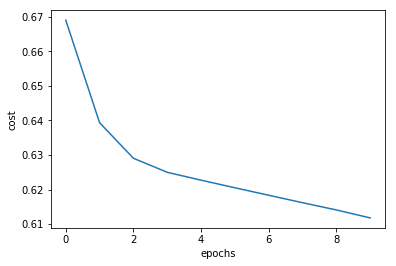

In [11]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

In [12]:
user_index = 150
x = np.array([Xtrain[user_index, :]])
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    recommender.set_session(sess)
    out = recommender.reconstruct(x.astype(np.float32))

In [13]:
score_movies_df = movies_df
score_movies_df["Recommendation_Score"] = out[0]
score_movies_df.sort_values(["Recommendation_Score"],  ascending=False).head(20)
score_movies_df.head()

,MovieID,Title,Genre,List_Index,Recommendation_Score
0,1,Toy Story (1995),Animation|Children's|Comedy,0,0.560319
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1,0.699984
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0.751833
3,4,Waiting to Exhale (1995),Comedy|Drama,3,0.894270
4,5,Father of the Bride Part II (1995),Comedy,4,0.238415


In [14]:
UID = merged_df.iloc[user_index]['UserID']

In [15]:
movies_df_UID = merged_df[merged_df['UserID']==UID]
merged_df_UID = pd.merge(score_movies_df,movies_df_UID, on='MovieID', how='outer')
merged_df_UID = merged_df_UID.drop('List_Index_y', axis=1).drop('UserID', axis=1)
merged_df_UID.sort_values(["Recommendation_Score"], ascending=False).head(5)


,MovieID,Title,Genre,List_Index_x,Recommendation_Score,Rating
1267,1287,Ben-Hur (1959),Action|Adventure|Drama,1267,0.999996,NaN
1094,1110,Bird of Prey (1996),Action,1094,0.999995,NaN
235,238,Far From Home: The Adventures of Yellow Dog (1...,Adventure|Children's,235,0.999995,NaN
914,926,All About Eve (1950),Drama,914,0.999991,NaN
1460,1490,B*A*P*S (1997),Comedy,1460,0.999989,NaN
